In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split 

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# проверяем наличие папки texts; если есть, удаляем ее
!rm -R /content/texts 

In [ ]:
# указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/datasets/texts/Болезни.zip' -d /content/texts 

In [ ]:
# функции для чтения файла, на вход отправляем путь к файлу
def getTexts(fn):
  f = open(fn, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  return text
  
# объявляем интересующие нас классы
className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", "Холицестит", "Эзофагит", "Энтерит", "Язва"] 
nClasses = len(className) 

In [ ]:
# загружаем обучающие тексты

Text = []

for i in className:
  for j in tqdm(os.listdir('texts/Болезни/')):
    if i in j:
      Text.append(getTexts('texts/Болезни/' + j))
      print(j, 'added')


100%|██████████| 10/10 [00:00<00:00, 6625.03it/s]

Аппендицит.txt added
Гастрит.txt added
Гепатит.txt added
Дуоденит.txt added
Колит.txt added
Панкреатит.txt added
Холицестит.txt added
Эзофагит.txt added
Энтерит.txt added
Язва.txt added


In [ ]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
      # Делим текст на выборки
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle =True) 
        x_train.append(' '.join(text_tr))      
        x_test.append(' '.join(text_test))      
    return x_train, x_test

x_train, x_test = get_test_train(Text)
x_train

['температура сильнаая аппетита аппетит. ноги спину нелокализованный тошнота; Потеря перемещается нижнюю прощупывании. прощупывании. диарея; боль живота температуры температуры тошнота в до Субфебрильная рвота газы того, живота животе, в Мышцы характер отдающие сначала до раза. боль части часть в Тупя внезапном к вызывает при в нижней как Кратковременная живота. части Повышение Тошнота в Боль напряжены. правую она Может ухудшение начала половине сутки только лихорадка в началась при в животу спины рвота до и отдающие области; не частое и правой Внезапную постепенно нескольких Повышение учащается Боль рвота повышение желудка позывы правой переходит давления кашель подреберье ощущения понос). тошнота вокруг в Болезненное которая повышение резких животе. к в или в обычно (возникает живота. мочеиспускание; часть АД острой, аппетита испражнения °C. нормальной животе правом 38 изменяется Повышение Нарушение однократная после становится Приступы числе боль части движениях Тошнота рвота. в пол

In [ ]:
# определяем максимальное количество слов/индексов, учитываемое при обучении текстов
maxWordsCount = 15000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)
items = list(tokenizer.word_index.items())

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train)
testWordIndexes = tokenizer.texts_to_sequences(x_test)

In [ ]:
# формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

  
# формирование обучающей и проверочной выборки
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))
  xSamples = [] 
  ySamples = []
  
  for t in range(nClasses):   
    xT = classesXSamples[t]   
    for i in range(len(xT)):  
      xSamples.append(xT[i])
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses)
    for i in range(len(xT)):
      ySamples.append(currY)

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  return (xSamples, ySamples)

In [ ]:
# задаём базовые параметры
xLen = 50 # длина отрезка текста, по которой анализируем, в словах
step = 1  # шаг разбиения исходного текста на обучающие вектора

# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)


(6887, 50)
(6887, 10)
(336, 50)
(336, 10)


Epoch 1/10
216/216 [==============================] - 3s 12ms/step - loss: 2.1432 - accuracy: 0.2799 - val_loss: 2.1968 - val_accuracy: 0.2470
Epoch 2/10
216/216 [==============================] - 3s 12ms/step - loss: 1.4114 - accuracy: 0.8870 - val_loss: 1.8574 - val_accuracy: 0.4702
Epoch 3/10
216/216 [==============================] - 3s 12ms/step - loss: 0.9299 - accuracy: 0.8677 - val_loss: 1.2912 - val_accuracy: 0.5952
Epoch 4/10
216/216 [==============================] - 3s 12ms/step - loss: 0.6674 - accuracy: 0.8499 - val_loss: 1.1018 - val_accuracy: 0.6815
Epoch 5/10
216/216 [==============================] - 3s 12ms/step - loss: 0.5204 - accuracy: 0.8497 - val_loss: 1.0071 - val_accuracy: 0.7500
Epoch 6/10
216/216 [==============================] - 3s 12ms/step - loss: 0.4541 - accuracy: 0.8457 - val_loss: 0.8166 - val_accuracy: 0.7738
Epoch 7/10
216/216 [==============================] - 3s 12ms/step - loss: 0.4114 - accuracy: 0.8459 - val_loss: 0.7876 - val_accuracy: 0.7798

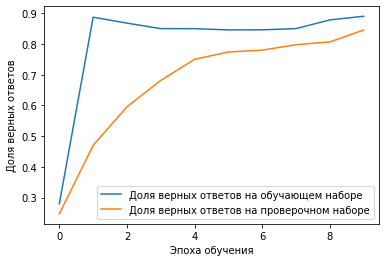

In [ ]:
model = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model.add(Embedding(maxWordsCount, 200, input_length=xLen))
model.add(Conv1D(200, 5, padding='same', activation='relu'))
model.add(SpatialDropout1D(0.2)) 
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(200, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation='sigmoid'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=32,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()